In [1]:
import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)
import pyvisa


# Example 1: generate a pulse repetitively 

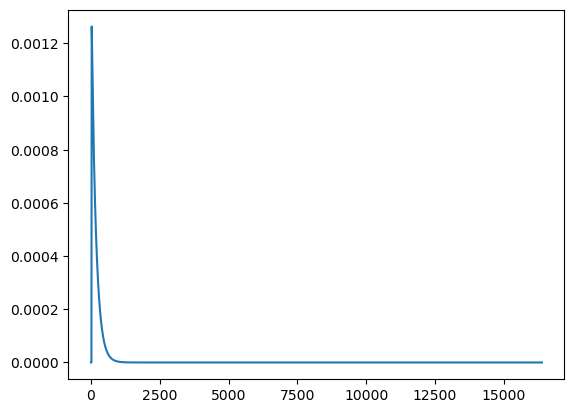

In [2]:
laser_pulse_parameter = [0.5725134262456216,0.5466275167850697,64.36634213846024,32.87753421632795,1.572835447536714,2.089784687599899,0.0012632000568868083]
waveform_length = 16384
samples_per_ns = 2.5 # 2.5 Gsps --> 2.5 samples per ns
samples_per_s = samples_per_ns*1e9
waveform_duration = waveform_length/samples_per_ns
ch=1

time_series = (np.arange(waveform_length)-10)/samples_per_ns
# time_series = (np.arange(waveform_length)-waveform_length//2)/samples_per_ns
waveform_1eh = hp.Pulse2(time_series, *laser_pulse_parameter)
# waveform_14bit = hp.float_to_ADU(waveform, bits=14)    
plot(waveform_1eh)


0.0006186995514619743


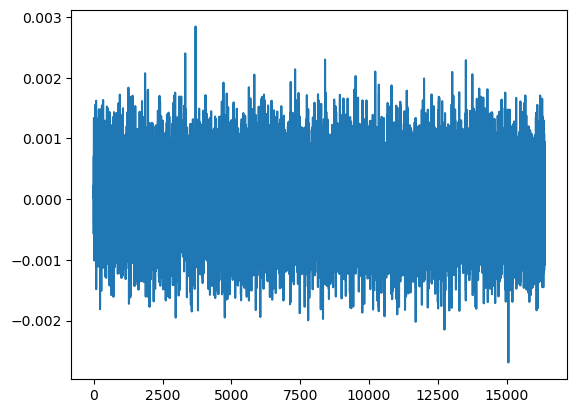

In [3]:
noise_voltage_density = 2.5*1e-9 * 7 # 2.5 nV/rtHz * gain=7
noise_trace = hp.band_limited_noise(0, 1.5e9, samples=waveform_length, samplerate=samples_per_s)* noise_voltage_density
plot(noise_trace)
print(std(noise_trace))

In [4]:
def mc_exp_decay(n_expected, n_threshold, WLS_t_decay, LASER_time_spread, N_EXPERIMENTS =4000, N_PLOTS=200,
                 SEED=1, PULSE=None, Fs=2.5, noise_voltage_density = 1e-9):

    # # Signal size and trigger
    # n_expected = 13.5 # number of eh expected
    # n_threshold = 4.5 # threshold [eh]

    # # WLS fiber parameter
    # WLS_t_decay = 2.7 # [ns]
    # # Laser parameter
    # LASER_time_spread = 0.15 # [ns], sigma, Gaus wavelet


    # # Run parameters
    # N_EXPERIMENTS = 10_000
    # N_PLOTS = 200
    # SEED = 1

    PULSE_DURATION = len(PULSE)/Fs
    TIME_SERIES = np.linspace(0,PULSE_DURATION,len(PULSE))
    RNG = np.random.default_rng(seed=SEED)

    results_trigger_time = []
    results_pulses = []
    for i in tqdm(range(N_EXPERIMENTS)):
        # Get the actual numer of photons by Sampling from poisson
        n_gen = RNG.poisson(lam=n_expected)
 
        if n_gen>0:
            pulse_this = np.zeros_like(PULSE)
            # Get the time of each photon by sampling from Gauss
            # time_gen = RNG.normal(loc=LASER_time_spread*7, scale=LASER_time_spread*7, size=n_gen)
            time_gen = 0
 
            # Get the decay time of each photon by sampling from exponential
            time_decay = time_gen + RNG.exponential(scale=WLS_t_decay, size=n_gen)
 
            for iphoton in range(n_gen):
                if time_decay[iphoton]>0 and time_decay[iphoton]<PULSE_DURATION:
                    # Roll and pile one more pulse to the final pulse
                    pulse_this+=roll_zeropad(PULSE, int(time_decay[iphoton]*Fs))
 
            results_trigger_time.append(np.argmax(pulse_this>(n_threshold*np.max(PULSE))))
    
            # Add in noise
            noise_trace = hp.band_limited_noise(0, 1.5e9, samples=len(PULSE), samplerate=int(Fs*1e9))* noise_voltage_density
            pulse_this+=noise_trace
 
            if i<N_PLOTS:
                results_pulses.append(pulse_this)
            

             
    results_trigger_time=np.array(results_trigger_time)   
    results_pulses=np.array(results_pulses)
    
    return results_trigger_time, results_pulses, TIME_SERIES

## Examples

In [11]:
# Signal size and trigger
n_expected = 15 # number of eh expected
n_threshold = 4.5 # threshold [eh]

# WLS fiber parameter
WLS_t_decay = 5 # [ns]
# Laser parameter
LASER_time_spread = 0.15 # [ns], sigma, Gaus wavelet


# Run parameters
N_EXPERIMENTS = 4000
N_PLOTS = N_EXPERIMENTS
SEED = 1


noise_temp = 0

results_trigger_time, results_pulses, _ = mc_exp_decay(n_expected, n_threshold, WLS_t_decay, LASER_time_spread,
                                                       N_EXPERIMENTS =N_EXPERIMENTS, N_PLOTS=N_PLOTS, SEED=SEED,
                                                       PULSE=waveform_1eh, Fs=samples_per_ns, noise_voltage_density=noise_temp)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1435.75it/s]


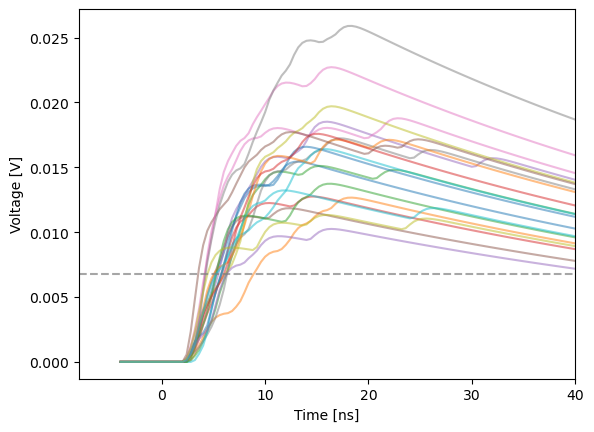

In [12]:
trigger_threshold = 0.0015*4.5


for i in range(20):
    plot(time_series, results_pulses[i],alpha=0.5)
    # plot(time_series, np.roll(results_pulses[i],-results_trigger_time[i]+8192),alpha=0.3)
xlim(-8,40)
xlabel("Time [ns]")
ylabel("Voltage [V]")
axhline(trigger_threshold, color="grey", linestyle="--", alpha=0.7)
show()

In [13]:
trigger_times = []
trigger_slope = []
for pulse in results_pulses:
    trigpt = int(np.argmax(pulse>trigger_threshold))
    trigger_times.append(time_series[trigpt])
    trigger_slope.append((pulse[trigpt+1]-pulse[trigpt])/(time_series[trigpt+1]-time_series[trigpt])*1000)
    # trigger_slope.append((pulse[trigpt+1]-pulse[trigpt])/(time_series[trigpt+1]-time_series[trigpt])*1000)

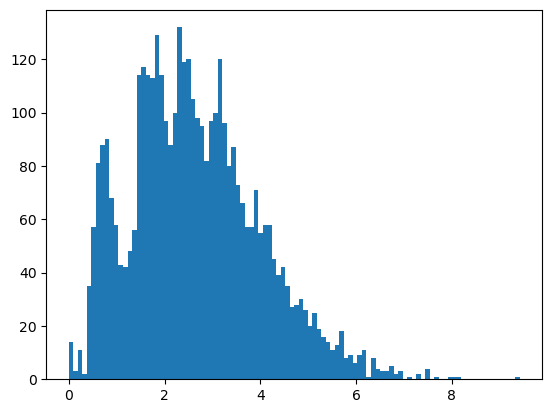

In [14]:
hist(trigger_slope,bins=100);

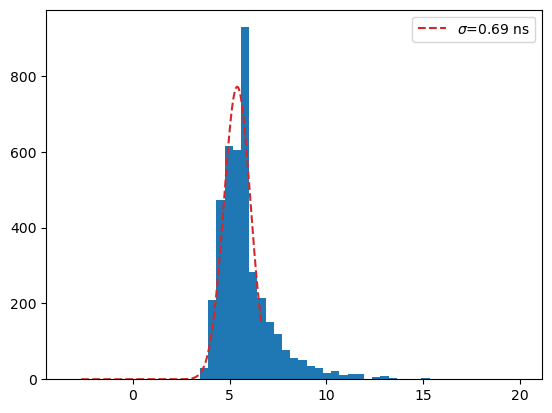

In [15]:
h = hist(trigger_times,bins=55, range=(-3.3,20));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--", fit_range=(-3,7));
legend()

In [5]:
amp_1eh_raw = np.max(waveform_1eh)*5/3
amp_1eh_at_asic = amp_1eh_raw*27/49
amp_1eh_at_disc = amp_1eh_at_asic*100
threshold = 0.15*20/63
threshold_eh = threshold/amp_1eh_at_disc
print(threshold_eh)

0.4104801260034944


In [17]:
# Signal size and trigger
n_expected = 10 # number of eh expected
n_threshold = 4.5 # threshold [eh]

# WLS fiber parameter
WLS_t_decay = 5 # [ns]
# Laser parameter
LASER_time_spread = 0.15 # [ns], sigma, Gaus wavelet


# Run parameters
N_EXPERIMENTS = 3600*3
N_PLOTS = N_EXPERIMENTS
SEED = 1

results_trigger_time, results_pulses, _ = mc_exp_decay(n_expected, n_threshold, WLS_t_decay, LASER_time_spread, N_EXPERIMENTS =N_EXPERIMENTS, N_PLOTS=N_PLOTS, SEED=SEED, PULSE=waveform_1eh, Fs=samples_per_ns, noise_voltage_density=noise_voltage_density)

100%|██████████| 10800/10800 [00:06<00:00, 1620.27it/s]


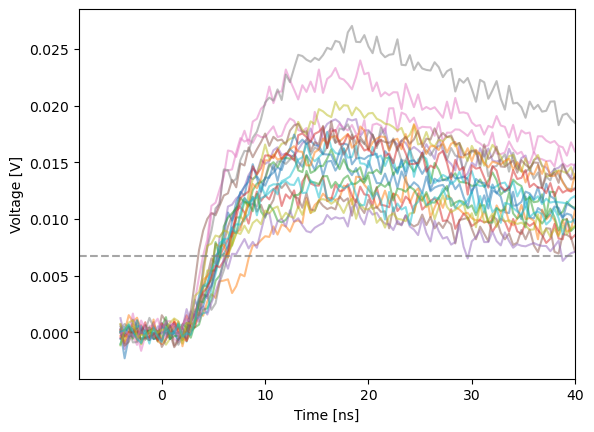

In [104]:
for i in range(20):
    plot(time_series, results_pulses[i],alpha=0.5)
    # plot(time_series, np.roll(results_pulses[i],-results_trigger_time[i]+8192),alpha=0.3)
xlim(-8,40)
xlabel("Time [ns]")
ylabel("Voltage [V]")
axhline(trigger_threshold, color="grey", linestyle="--", alpha=0.7)
show()



trigger_times = []
for pulse in results_pulses:
    trigger_times.append(time_series[np.argmax(pulse>trigger_threshold)])

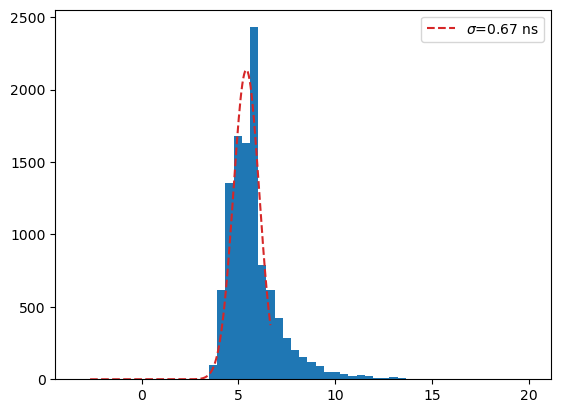

In [105]:
h = hist(trigger_times,bins=55, range=(-3.3,20));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--", fit_range=(-3,7));
legend()

In [106]:
dummy_pulse_avg = np.mean(results_pulses, axis=0)
scintillator_pulse_15eh_save = np.load("scintillator_pulse_15eh.npy")
time_series_15eh, scintillator_pulse_15eh, scintillator_pulse_15eh_std = scintillator_pulse_15eh_save

In [107]:
time_series2 = (np.arange(waveform_length)-waveform_length//2)/samples_per_ns
waveform_1eh2 = hp.Pulse2(time_series2, *laser_pulse_parameter)

decay_kernel = scipy.stats.expon.pdf(time_series2, scale=WLS_t_decay)
waveform_1eh_smeared = scipy.signal.convolve(waveform_1eh2,decay_kernel, mode="same")

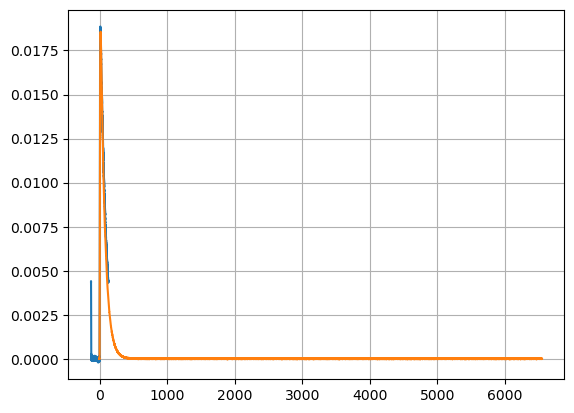

In [108]:
# plot(time_series2, waveform_1eh2)
plot(time_series_15eh, scintillator_pulse_15eh)
# plot(time_series2-0.3, waveform_1eh_smeared/max(waveform_1eh_smeared)*max(dummy_pulse_avg))
plot(time_series-3.5, dummy_pulse_avg*1.15)

xlim(-10,50)
grid()

# Open the function generator and generate pulses

In [7]:
# funcgen = vs.connect(timeout=30000) # set 30 second timeout
funcgen = vs.connect("TCPIP0::192.168.1.9::inst0::INSTR", timeout=10000) # set 30 second timeout
# funcgen = vs.connect("USB0::0x0957::0x4108::MY60410882::0::INSTR", timeout=10000) # set 30 second timeout
# vs.disconnect(funcgen)

Connected to VISA [TCPIP0::192.168.1.9::inst0::INSTR]:  Agilent Technologies,81160A,MY60410882,2.0.0.0-2.6



In [20]:
vs.disconnect(funcgen)

## 1. Generate toy data waveform

In [11]:
funcgen.write(":DISP OFF");

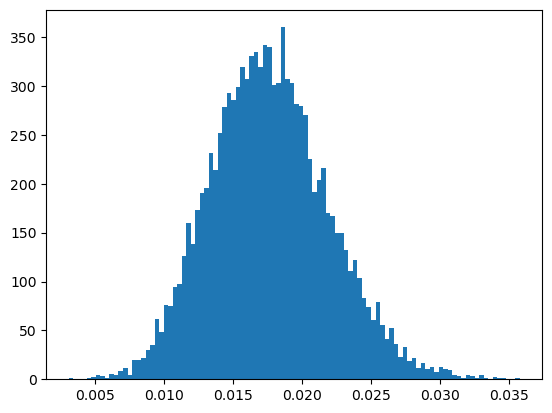

In [109]:
amps=[max(pulse) for pulse in results_pulses]
hist(amps,bins=100);

In [19]:
for i in tqdm(range(len(results_pulses))):
# for i in tqdm(range(7000)):
# for i in tqdm(range(20)):
    
    INIT = True if i==0 else False

    # INIT=False

    funcgen.write(f":OUTPut1 OFF");      # Output the selected arb waveform  
    # funcgen.write(f":OUTPut2 OFF");      # Output the selected arb waveform  

    # Upload the first waveform
    j = np.random.randint(0,len(results_pulses))
    waveform_14bit = hp.float_to_ADU(results_pulses[j], bits=14)  
    output_voltage = np.max(results_pulses[j])*10*49/27
    if output_voltage<0.05:
        output_voltage = 0.05
    vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=1, trigger_mode="MAN", output_voltage=output_voltage, RESET=False, INIT=INIT)
    time.sleep(0.01)
    
    
    # Upload the second waveform
    # j = np.random.randint(0,len(results_pulses))
    # waveform_14bit = hp.float_to_ADU(results_pulses[j], bits=14)  
    # output_voltage = np.max(results_pulses[j])*10
    # if output_voltage<0.05:
    #     output_voltage = 0.05
    # vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=2, trigger_mode="MAN", output_voltage=output_voltage, RESET=False, INIT=INIT)
    # time.sleep(0.01)    
    
    funcgen.write(f":OUTPut1 ON");      # Output the selected arb waveform  
    # funcgen.write(f":OUTPut2 ON");      # Output the selected arb waveform        
    
    vs.trigger(funcgen)

    time.sleep(0.1)

 48%|████▊     | 5161/10798 [23:35<25:45,  3.65it/s] 


KeyboardInterrupt: 

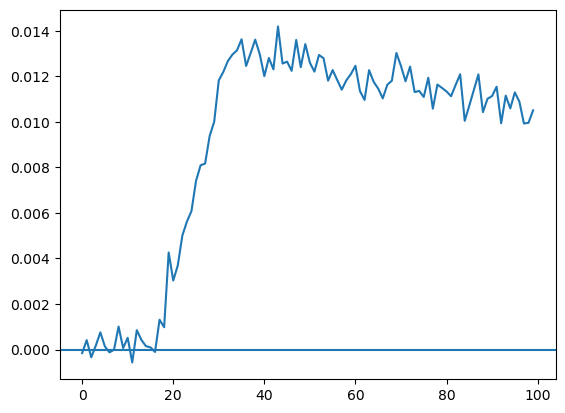

In [94]:
plot(results_pulses[j][:100])
axhline(0)

## 2. Generate the same averaged pulse 

In [417]:
dummy_pulse_avg_normd = dummy_pulse_avg/max(dummy_pulse_avg)
output_voltage = max(dummy_pulse_avg)*20
waveform_14bit = hp.float_to_ADU(-dummy_pulse_avg, bits=14)  
vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=ch, trigger_mode="MAN",trigger_freq=500, output_voltage=output_voltage, RESET=False)

In [326]:
for i in tqdm(range(10000)):
    vs.trigger(funcgen)
    time.sleep(0.003)    

 72%|███████████████████████████████████████████████████████▋                     | 7231/10000 [01:52<00:42, 64.51it/s]


KeyboardInterrupt: 

# Analysis

In [483]:
DATA_DIR = "E:\\sync\\DT5550W\\"
filename = f"{DATA_DIR}\\176.data"

data  = hpt.load_finetime(filename, chs =["16","17"])

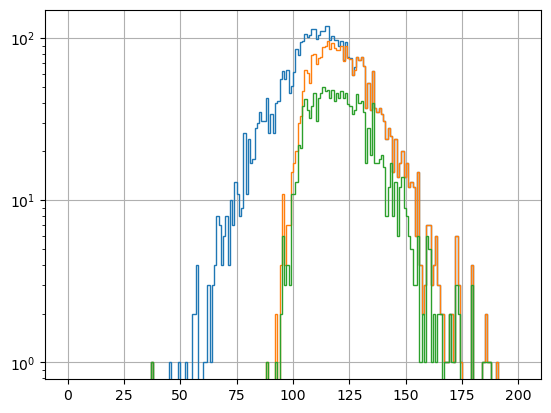

In [498]:
mask_hit16 = (data["HIT_16"]==1)
mask_hit17 = (data["HIT_17"]==1)
mask_coinc = mask_hit16&mask_hit17

hist((data["CHARGE_17"]),bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_hit17],bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_coinc],bins=np.linspace(0,200,201),histtype="step", label="CH16");
yscale("log")
grid()

In [501]:
sum(mask_hit16)

3195

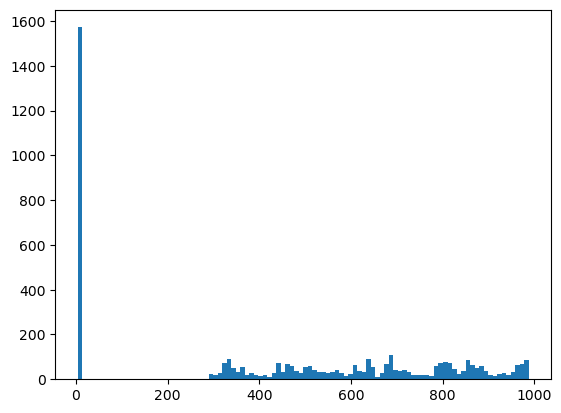

In [496]:
h=hist(data["FINE_17"], bins=100);


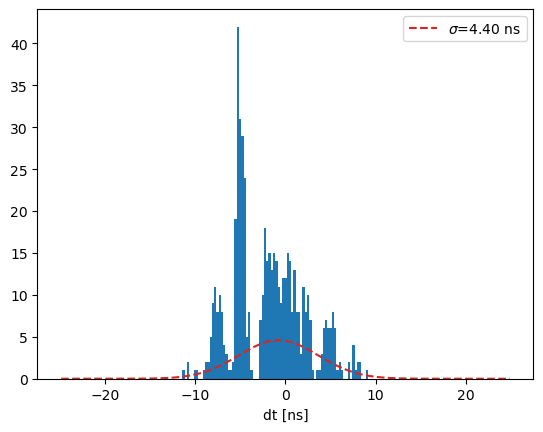

In [477]:
dt_coinc = (data.TIMESTAMP_16-data.TIMESTAMP_17)


ftime_min=ftime_max=None
bins=np.linspace(0,25,240)
ch="0"
normed=False

mask_peak1 = mask_coinc& (np.abs(data["CHARGE_17"]-100)<15)

h=hist(dt_coinc[mask_peak1], bins=np.linspace(-25,25,200));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    

In [478]:
import random

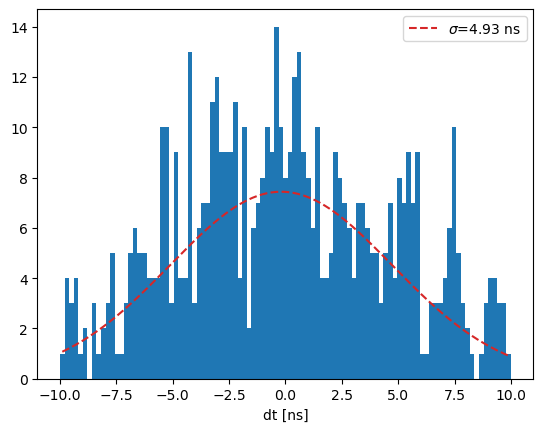

In [479]:
inds1 = np.arange(len(dt_coinc))
inds2 = np.arange(len(dt_coinc))
random.shuffle(inds1)
random.shuffle(inds2)

dt_coinc_shuffled = dt_coinc.values[inds1]-dt_coinc.values[inds2]

bins=np.linspace(0,25,240)

h=hist(dt_coinc_shuffled, bins=np.linspace(-10,10,100));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    

In [343]:
3.7/1.4

2.6428571428571432

### Averaged pulse

In [391]:
DATA_DIR = "E:\\sync\\DT5550W\\"
filename = f"{DATA_DIR}\\174.data"

data  = hpt.load_finetime(filename, chs =["16","17"])

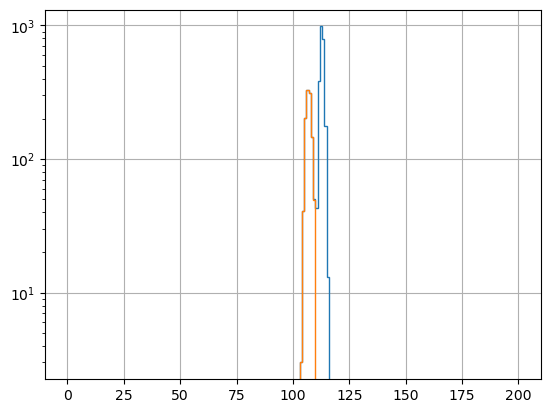

In [342]:
mask_hit16 = (data["HIT_16"]==1)
mask_hit17 = (data["HIT_17"]==1)
mask_coinc = mask_hit16&mask_hit17

hist((data["CHARGE_17"]),bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_coinc],bins=np.linspace(0,200,201),histtype="step", label="CH16");
yscale("log")
grid()

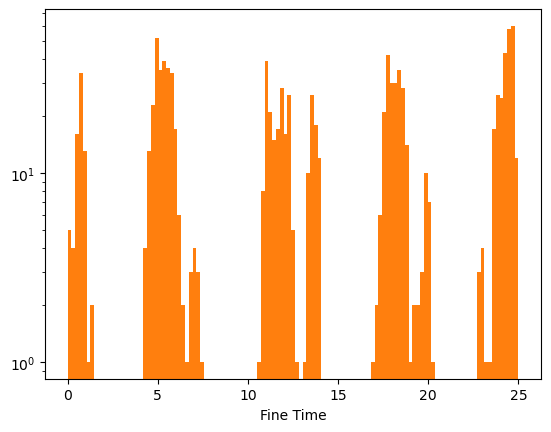

In [396]:
bins=np.linspace(0,25,120)

hist(data.FINE_calib_17, bins=bins)
hist(data.FINE_calib_17[mask_coinc], bins=bins)
xlabel("Fine Time")
yscale("log")

In [332]:
sum(mask_coinc)/len(mask_coinc)

0.3104641106947247

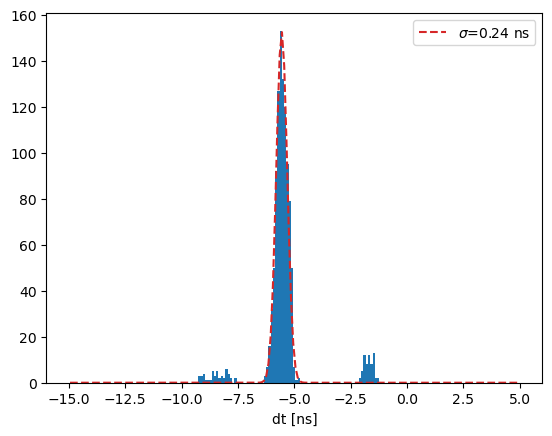

In [331]:
dt_coinc = (data.TIMESTAMP_16-data.TIMESTAMP_17)


ftime_min=ftime_max=None
bins=np.linspace(0,25,240)
ch="0"
normed=False

mask_peak1 = mask_coinc#& (np.abs(data["CHARGE_17"]-100)<15)

h=hist(dt_coinc[mask_peak1], bins=np.linspace(-15,5,200));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    